## Imports

### Install packages

In [37]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

### Import modules

In [38]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux 4977b124a6ac 6.12.5-linuxkit #1 SMP Tue Jan 21 10:23:32 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.1
arviz version=0.21.0
preliz version=0.4.1


In [40]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 6)

# g-h filter

In [41]:
n_samples = 12

# We assume we know the real weight.
ground_truth = 160.0 + np.arange(0, n_samples)

# This is what we measure.
measured_weights = np.array([
    158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0,
    171.2, 172.6
])

## Knowing gain_rate

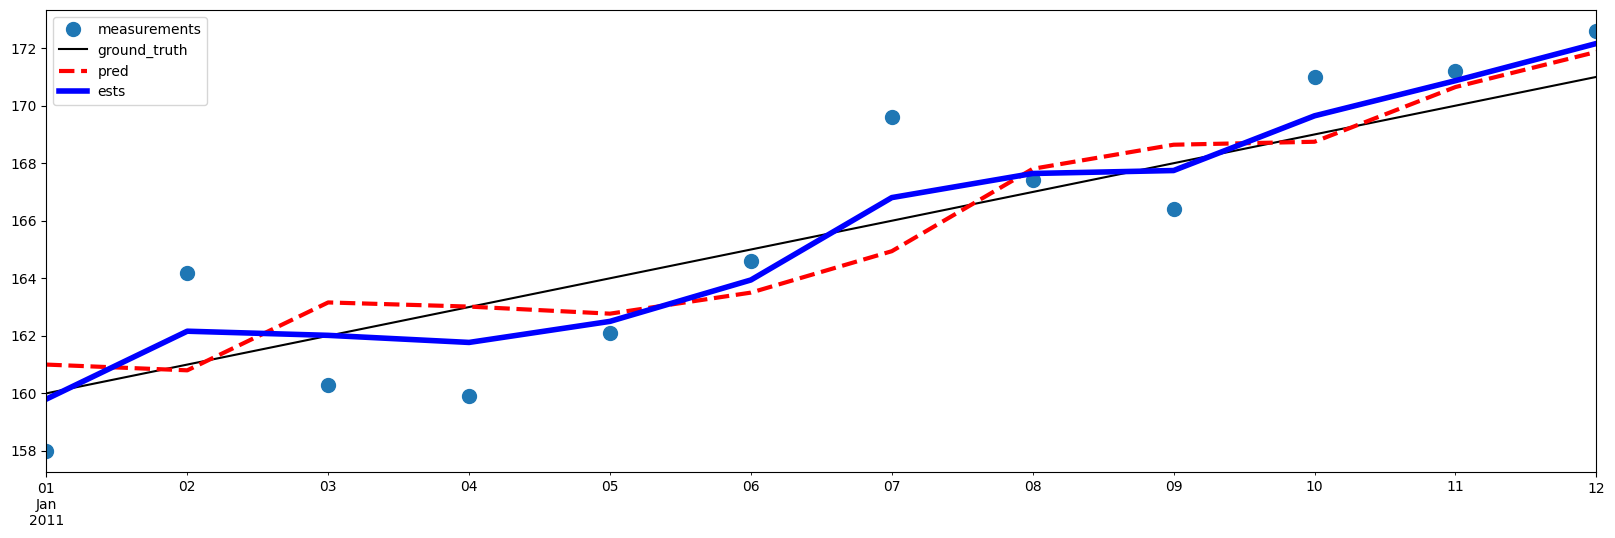

In [42]:
time_step = 1
# This is the blending factor.
weight_scale = 4 / 10.0
# This is the internal model.
gain_rate = 1.0
# This is the initial weight.
weight = 160.0

ests, preds = ut.predict_using_gain_guess(
    weight, measured_weights, gain_rate, weight_scale, time_step)

ut.plot_gh_filter_results(measured_weights, preds, ests, ground_truth)

## Wrong guess of gain_rate

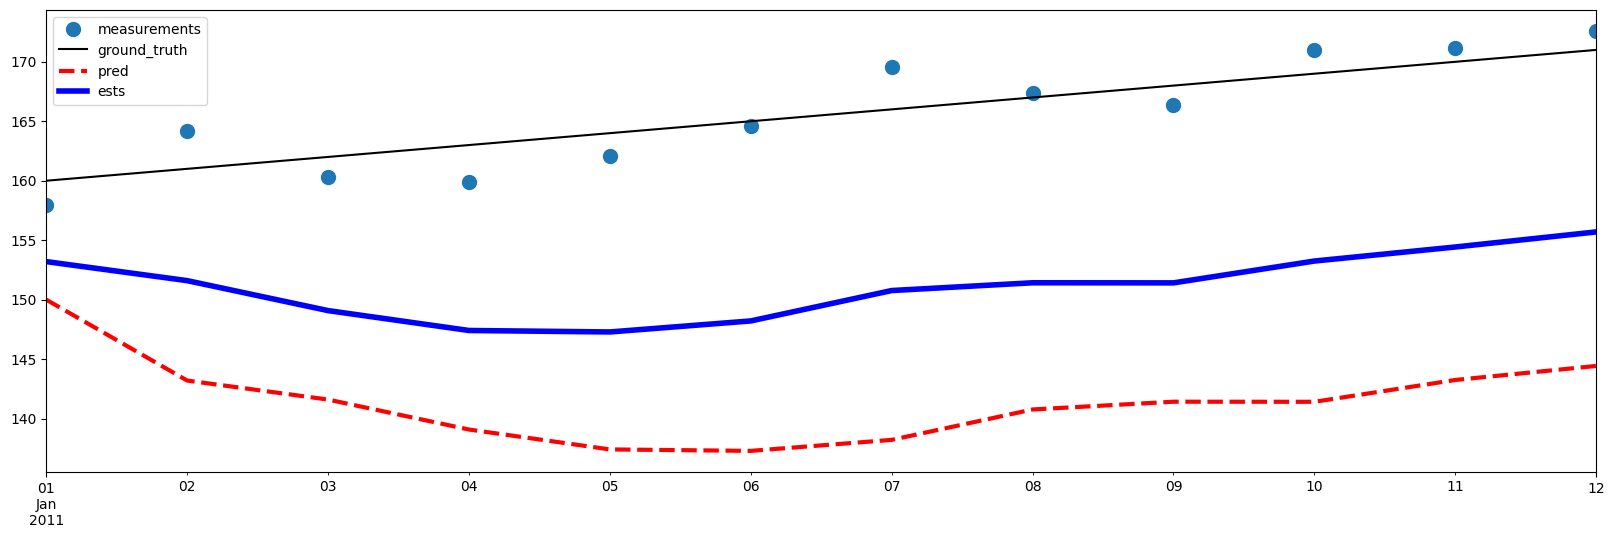

In [43]:
time_step = 1
weight_scale = 4 / 10.0
gain_rate = -10.0
weight = 160.0

ests, preds = ut.predict_using_gain_guess(
    weight, measured_weights, gain_rate, weight_scale, time_step)

ut.plot_gh_filter_results(measured_weights, preds, ests, ground_truth)

## Learning gain_rate

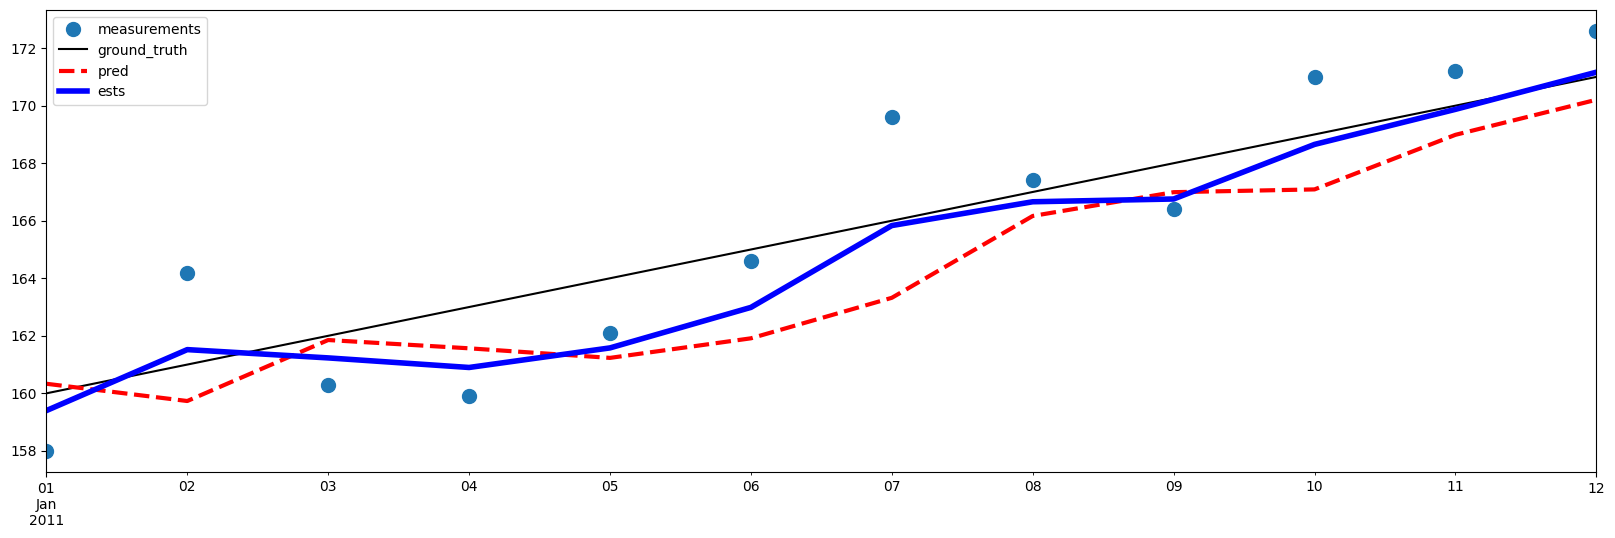

In [44]:
time_step = 1
# Gains for update step.
weight_scale = 4 / 10.0
gain_scale = 1 / 3.0
# Initial guess of gain_rate.
gain_rate = -1.0
weight = 160.0

ests, preds = ut.predict_learning_gain_rate(
    weight, measured_weights, gain_rate, weight_scale, gain_scale, time_step)

ut.plot_gh_filter_results(measured_weights, preds, ests, ground_truth)

## Noisy measurements

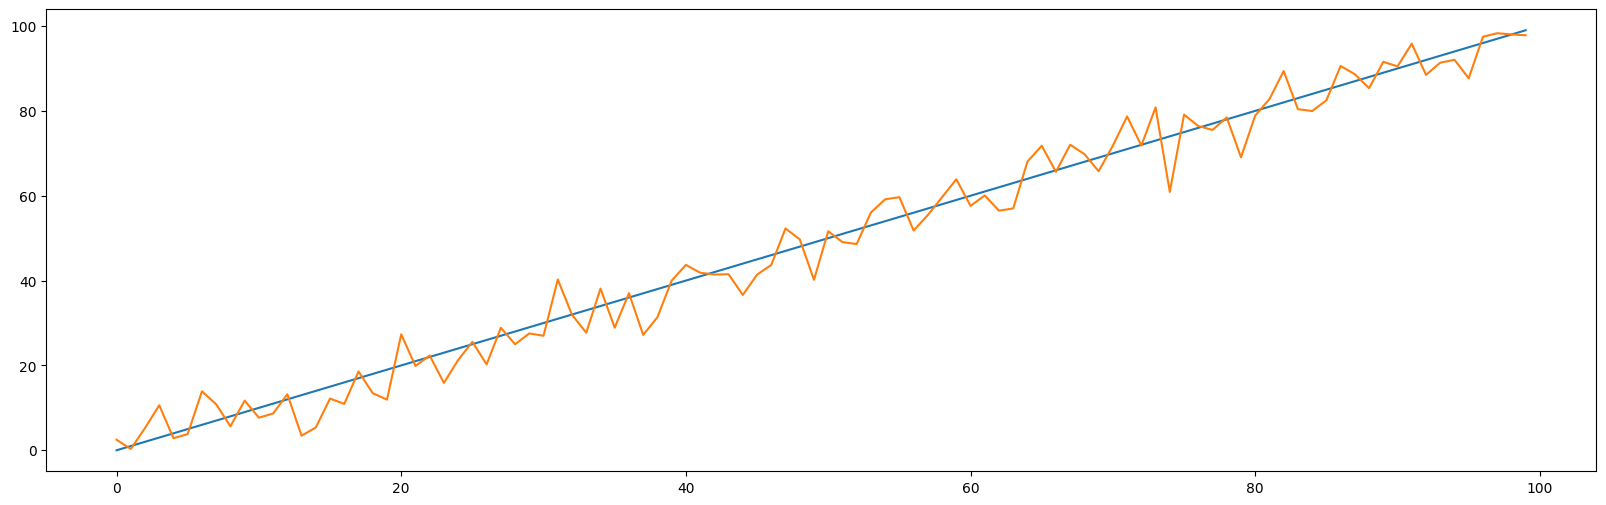

In [45]:
vals, ground_truth = ut.gen_linear_noisy_data(x0=0, dx=1, count=100, noise_factor=5)
# TODO(gp): Fix this.
pd.Series(ground_truth).plot();
pd.Series(vals).plot();

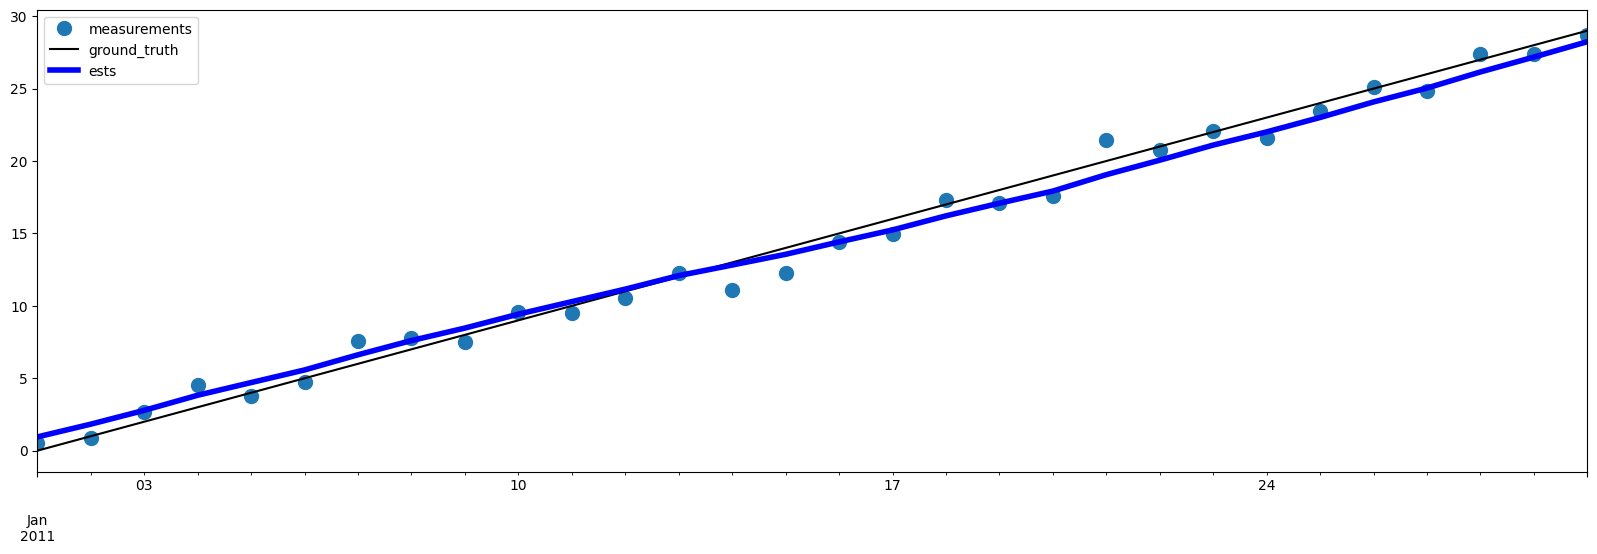

In [46]:
vals, ground_truth = ut.gen_linear_noisy_data(x0=0, dx=1, count=30, noise_factor=1)
ests = ut.gh_filter(data=vals,
                  # Initial guesses (actually correct!).
                  x0=0, dx=1, dt=1,
                  # g, h params.
                  g=0.1, h=0.02)

preds = None
ut.plot_gh_filter_results(vals, preds, ests, ground_truth)

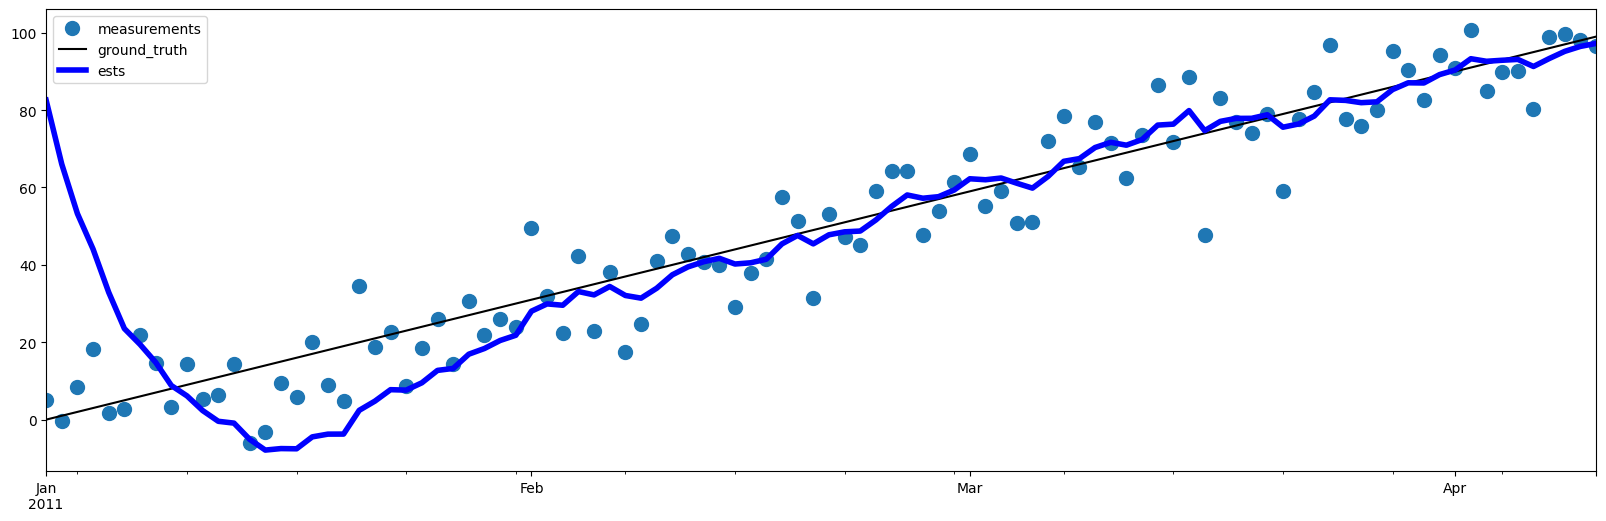

In [47]:
# Wrong initial guess for state.
vals, ground_truth = ut.gen_linear_noisy_data(x0=0, dx=1, count=100, noise_factor=10)
ests = ut.gh_filter(data=vals,
                  # Initial guesses (wrong!).
                  x0=100, dx=2,
                  dt=1, g=0.2, h=0.02)
preds = None
ut.plot_gh_filter_results(vals, preds, ests, ground_truth)

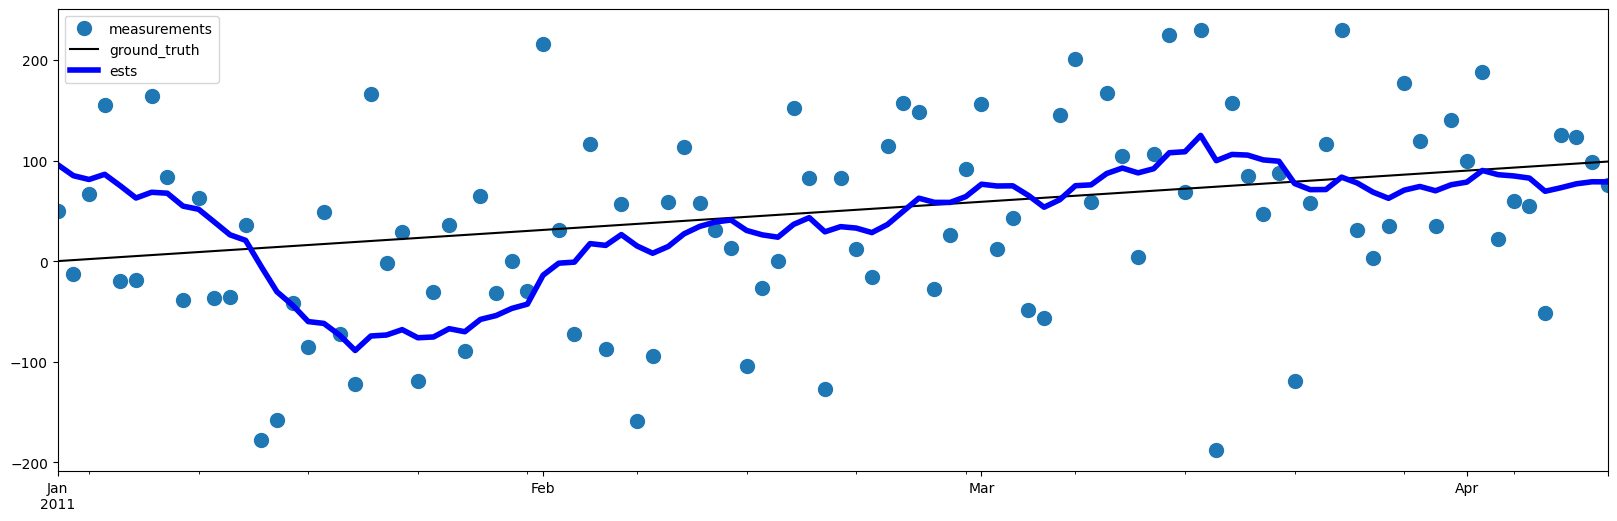

In [48]:
# Extreme noise.
vals, ground_truth = ut.gen_linear_noisy_data(x0=0, dx=1, count=100, noise_factor=100)
ests = ut.gh_filter(data=vals, x0=100, dx=1, dt=1, g=0.1, h=0.02)
preds = None
ut.plot_gh_filter_results(vals, preds, ests, ground_truth)

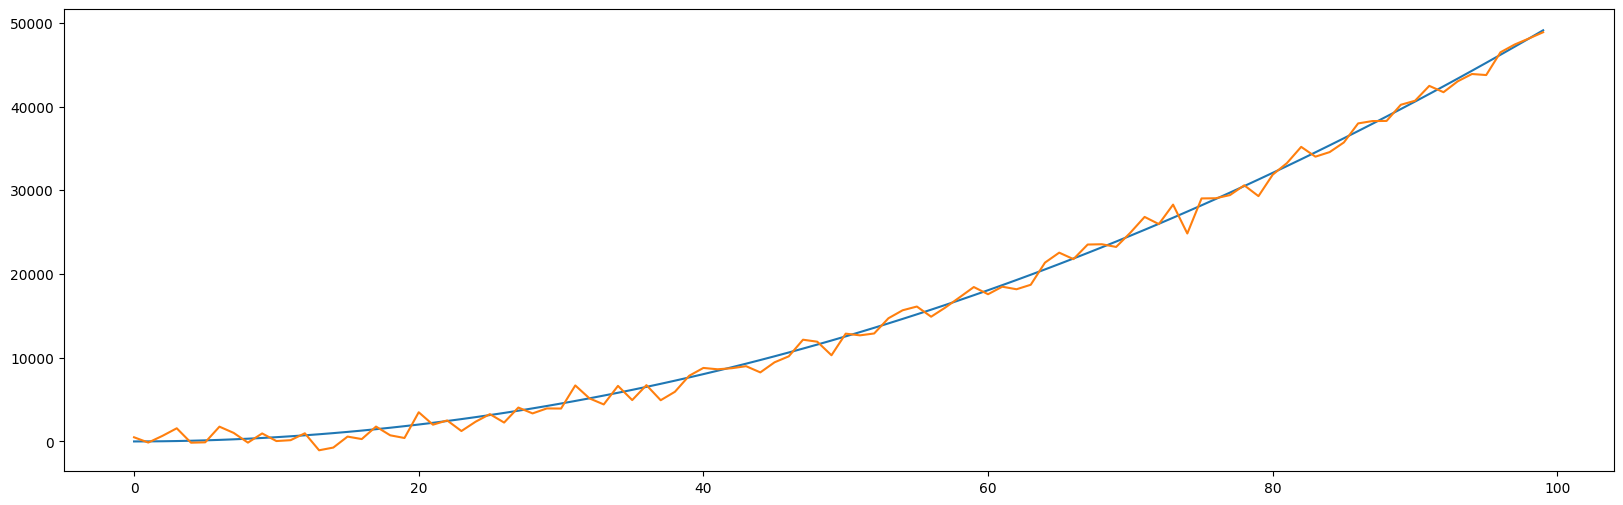

In [49]:
# Non linear ground truth.
vals, ground_truth = ut.gen_non_linear_noisy_data(x0=0, dx=1, count=100, noise_factor=1000, accel=5)

# TODO(gp): Fix this.
pd.Series(ground_truth).plot();
pd.Series(vals).plot();

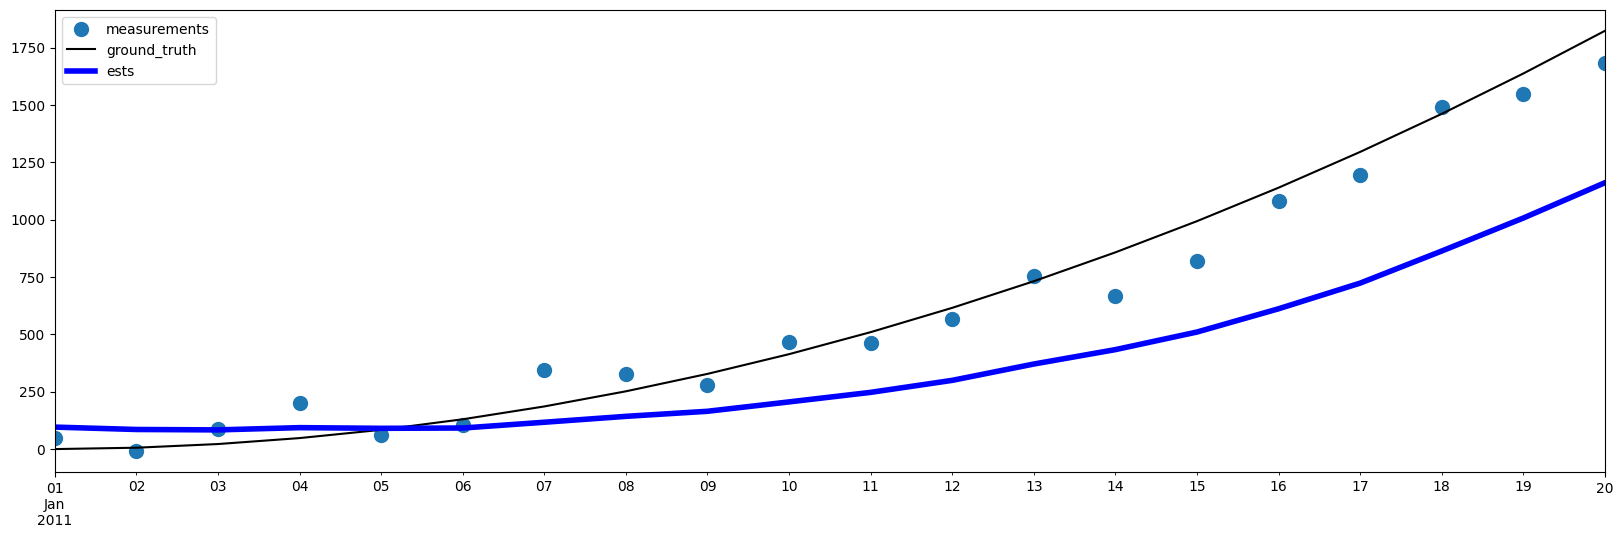

In [50]:
vals, ground_truth = ut.gen_non_linear_noisy_data(x0=0, dx=1, count=20, noise_factor=100, accel=5)
ests = ut.gh_filter(data=vals, x0=100, dx=1, dt=1, g=0.1, h=0.02)

preds = None
ut.plot_gh_filter_results(vals, preds, ests, ground_truth)

## Varying g

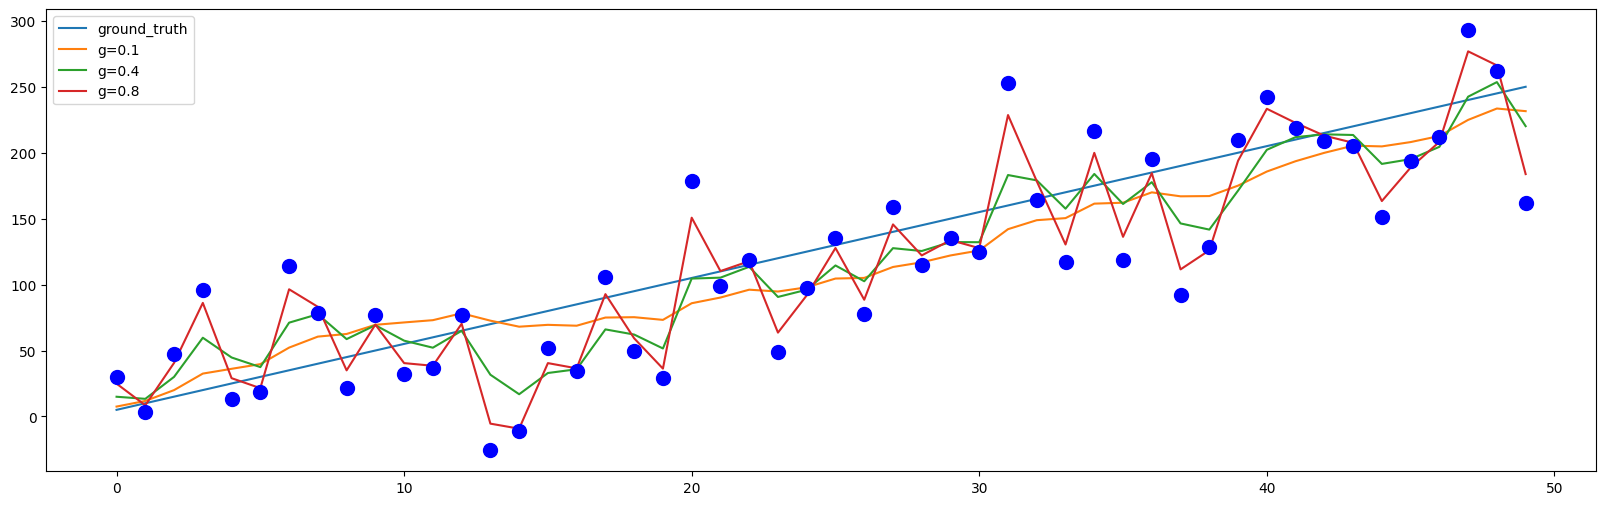

In [51]:
# If g is smaller we follow more our model than the measurements.
# If g is larger we follow more the measurements than our model
# If g is too large we follow the measurements and reject no noise.
np.random.seed(100)
zs, ground_truty = ut.gen_linear_noisy_data(x0=5, dx=5, count=50, noise_factor=50)
df = pd.DataFrame(zs)
df.columns = ["measures"]

df["ground_truth"] = ground_truty
df["g=0.1"] = ut.gh_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
df["g=0.4"] = ut.gh_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
df["g=0.8"] = ut.gh_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

df.drop("measures", axis=1).plot()
df["measures"].plot(marker="o", markersize=10, color="b",
                    # Hide line.
                    linestyle='None');

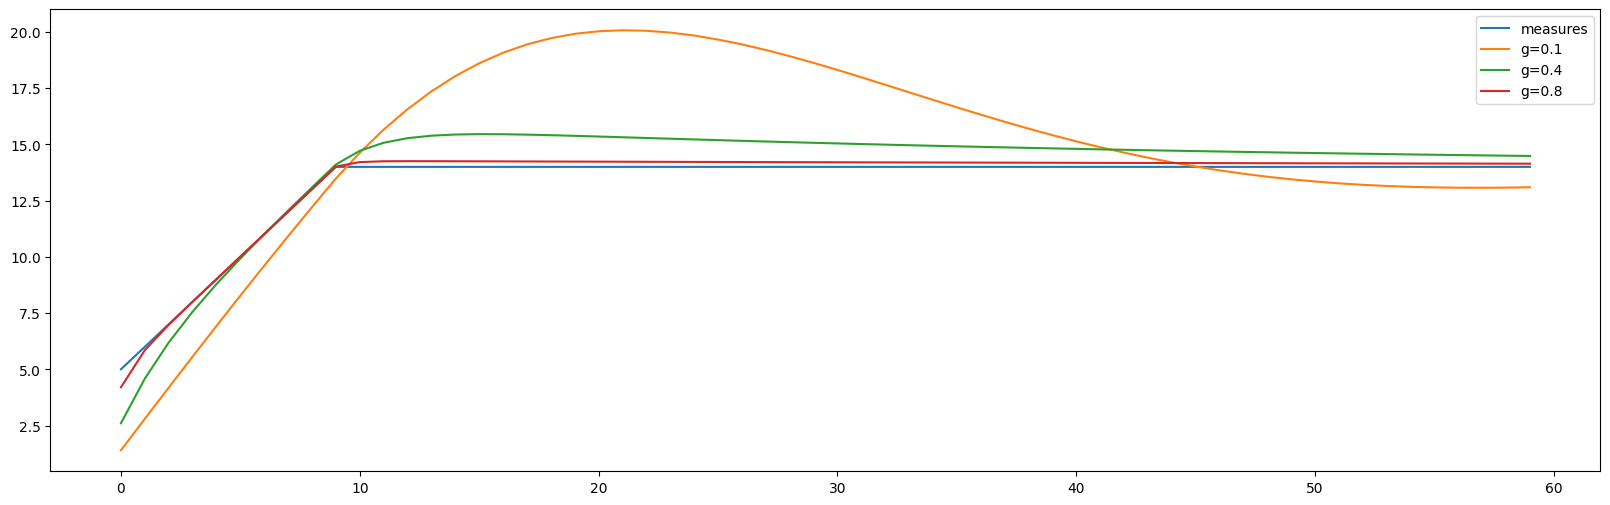

In [52]:
# If g is large we follow more the measures than our model.
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)
df = pd.DataFrame(zs)
df.columns = ["measures"]

df["g=0.1"] = ut.gh_filter(data=zs, x0=0., dx=1, dt=1., g=0.1, h=0.01)
df["g=0.4"] = ut.gh_filter(data=zs, x0=0., dx=1, dt=1., g=0.4, h=0.01)
df["g=0.8"] = ut.gh_filter(data=zs, x0=0., dx=1, dt=1., g=0.8, h=0.01)

df.plot();

## Varying h
- h affects how much we favor the measurement of $\frac{dx}{dt}$ vs our prediction
- If the signal is varying a lot, then we will react to the transient rapidly

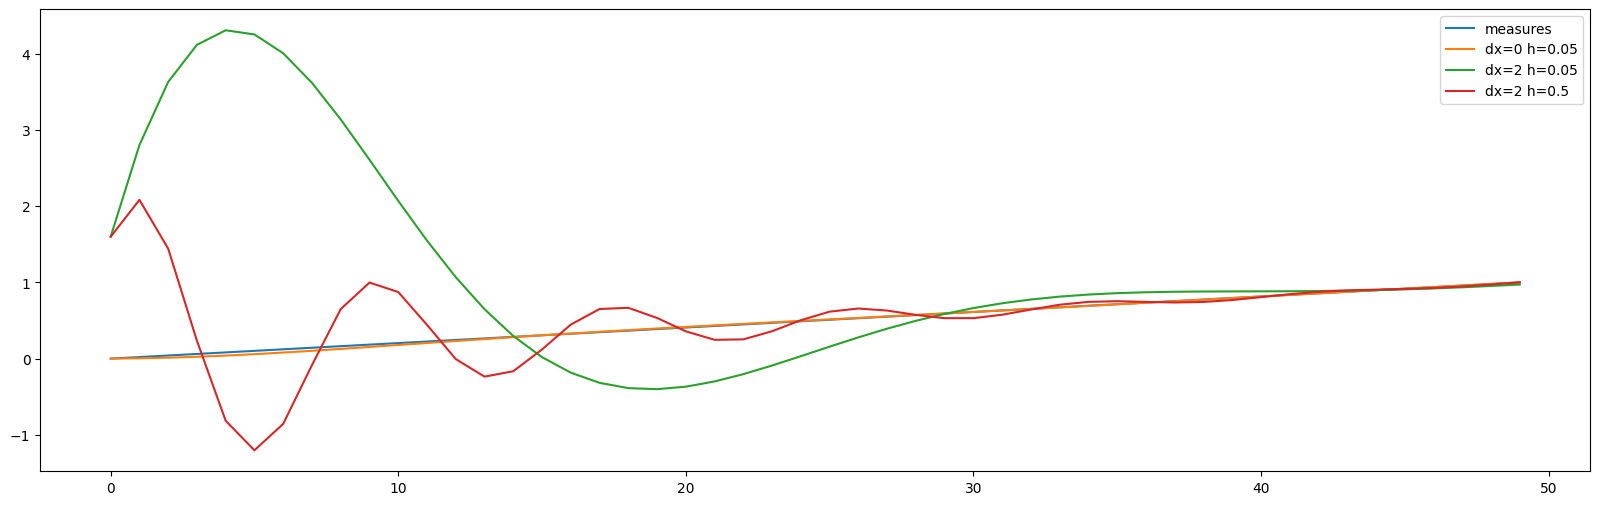

In [53]:
# Go from 0 to 1 in 50 steps (dx = 1 / 50 = 0.02) without noise.
zs = np.linspace(0, 1, 50)
df = pd.DataFrame(zs)
df.columns = ["measures"]

# dx is close to ground truth with small h.
# We track the signal right.
df["dx=0 h=0.05"] = ut.gh_filter(data=zs, x0=0, dx=0, dt=1.0, g=.2, h=0.05)

# dx is wrong, with small h.
# There is big ringing, and we adapt slowly (lower frequency).
df["dx=2 h=0.05"] = ut.gh_filter(data=zs, x0=0, dx=2, dt=1.0, g=.2, h=0.05)

# dx is wrong, with large h.
# Small ringing with higher frequency.
df["dx=2 h=0.5"] = ut.gh_filter(data=zs, x0=0, dx=2, dt=1.0, g=.2, h=0.5)

df.plot();

# Interactice example

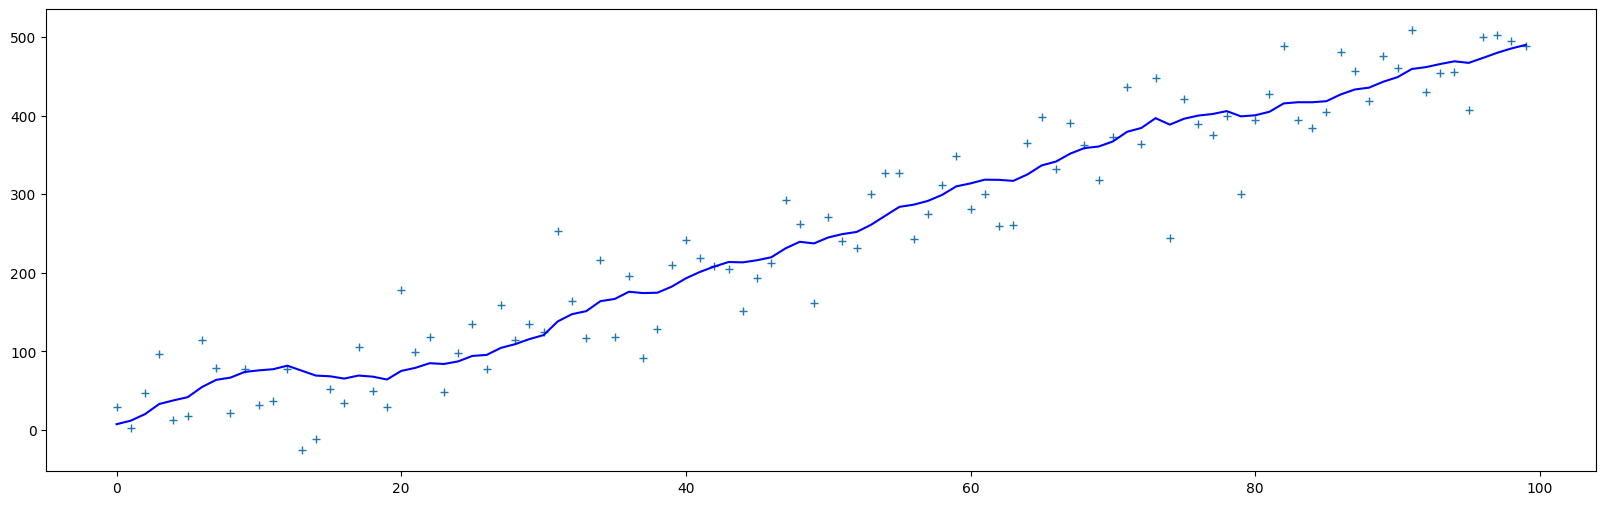

In [57]:
zs1, _ = ut.gen_linear_noisy_data(x0=5, dx=5, count=100, noise_factor=50)

fig = None

def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None:
        plt.close(fig)
    fig = plt.figure()
    data = ut.gh_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(list(range(len(zs1))), zs1, marker="+", lw=1)
    plt.plot(data, color='b')
    
interactive_gh(0, 5, 0.1, 0.02)

In [56]:
from ipywidgets import interact, FloatSlider

interact(interactive_gh,
         x=FloatSlider(value=0., min=-200, max=2000, continuous_update=False),
         dx=FloatSlider(value=5., min=-50., max=50, continuous_update=False),
         g=FloatSlider(value=0.1, min=0.01, max=2, step=.02, continuous_update=False), 
         h=FloatSlider(value=0.02, min=0.0, max=0.5, step=0.01, continuous_update=False));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=2000.0, min=-200.0)…

## Discrete Bayes Filter

In [58]:
belief = np.array([1.0 / 10] * 10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


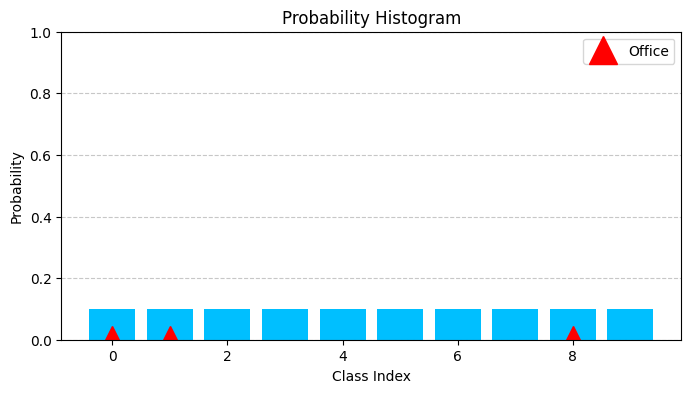

In [65]:
ut.plot_dog_in_office_pdf(belief)

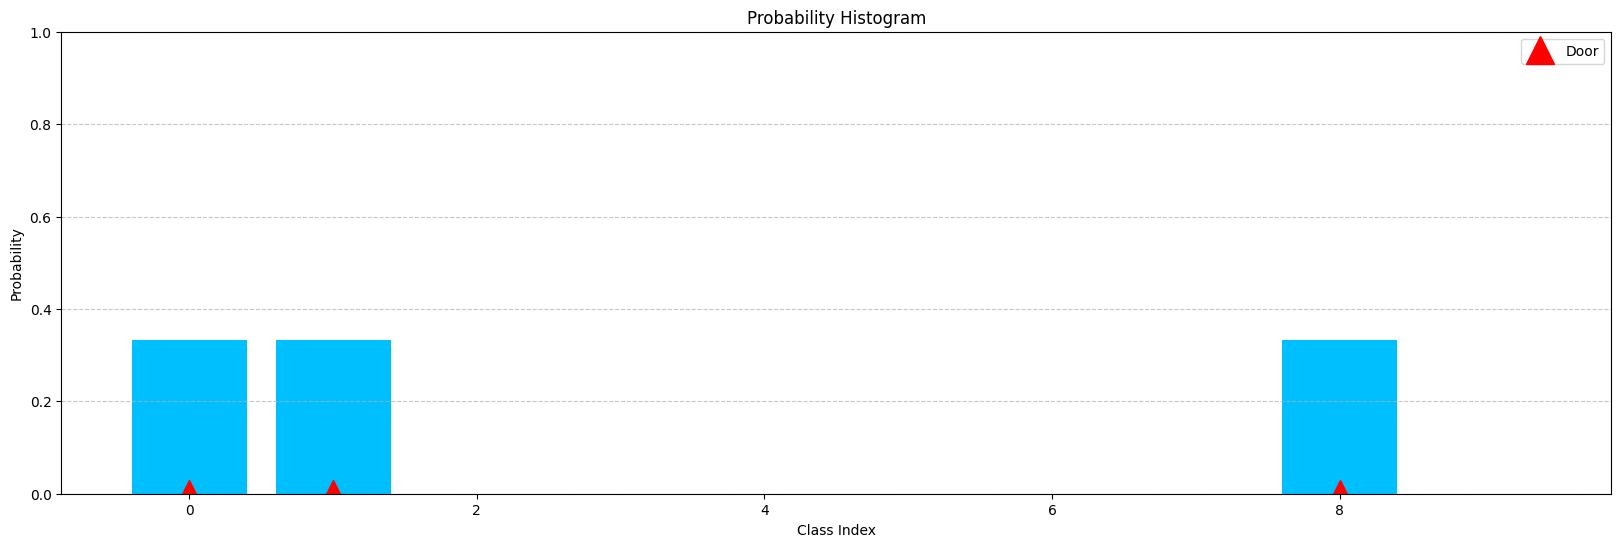

In [67]:
# The sensor says the dog is in front of a door.
belief = np.array([1/3, 1/3, 0, 0, 0, 0, 0, 0, 1/3, 0])
ut.plot_dog_in_office_pdf(belief)

In [68]:
# If the sensor reports "door", "move right", "door", we know that the door is at position 0.
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
ut.plot_dog_in_office_pdf(belief)

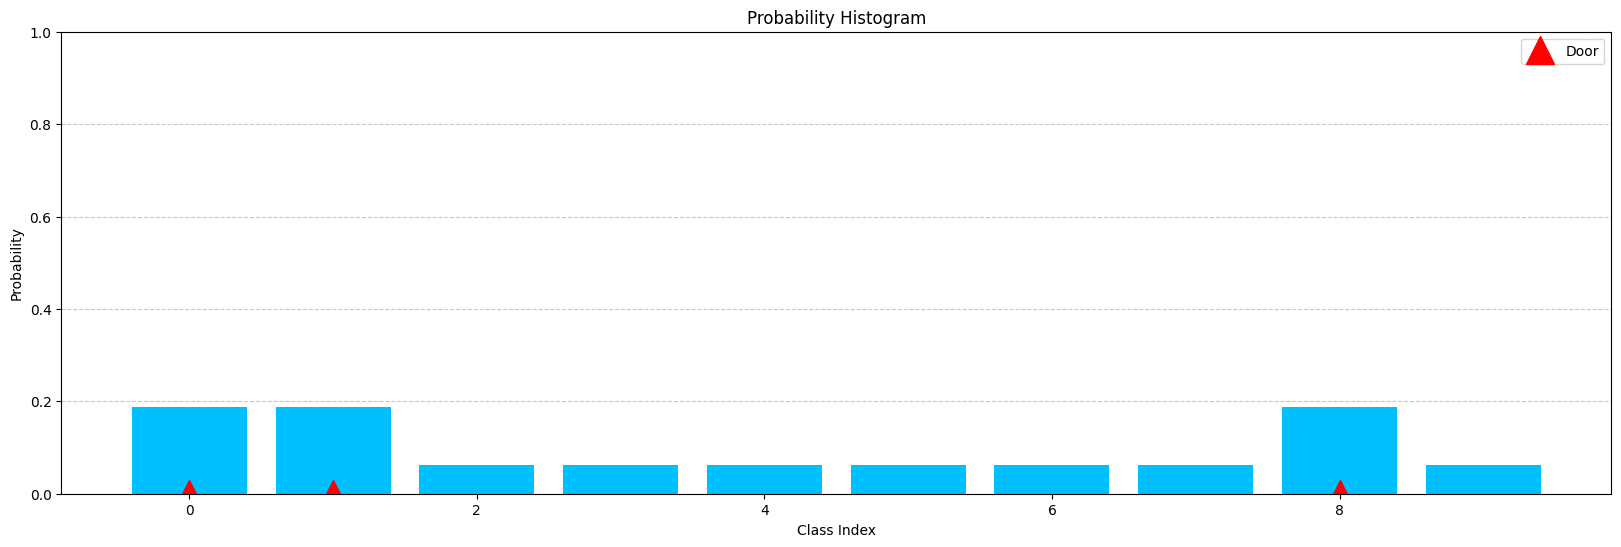

In [72]:
# If sensors are noisy we can't conclude with certainty that we are in front of a door.
# Assume that the sensor is 3x more likely to be right than wrong
# - We need to scale the probability by 3 and then normalize it to sum to 1
belief = np.array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])
belief /= sum(belief)
ut.plot_dog_in_office_pdf(belief)